# Proyek Analisis Data: Bike Sharing Dataset
- **Nama:** Favian Naufal
- **Email:** faviannauu@gmail.com
- **ID Dicoding:** favian_naufal_CdOf

**Note**: Pardon my inconsistency of the language usage. Although it accidentally shows that this project was done on separate sessions.

## Menentukan Pertanyaan Bisnis

1. **Apakah kondisi cuaca mempengaruhi performa peminjaman Sepeda Rental?** <br>
  Pertanyaan ini melibatkan beberapa atribut data berikut ini; `cnt` *count* sepeda rental yang digunakan di setiap harinya. `weathersit`, `temp`, `hum` dan `windspeeed`. Pertanyaan ini bertujuan untuk menganalisis performa peminjaman sepeda rental terhadap setiap kondisi cuaca yang ada di hari tersebut.
2. **Apakah terdapat perbedaan performa peminjaman Sepeda Rental terhadap penggunaanya oleh *casual users* pada rentang waktu *weekday*, *weekend*, dan *holiday*?**
   Pertanyaan ini melibatkan beberapa atribut data berikut ini; `cnt` *count* sepeda rental yang digunakan di setiap harinya. `dteday`, `weekday`, dan `workingday`. Pertanyaan ini bertujuan untuk menganalisis perbandingan performa peminjaman sepeda rental oleh pengguna kasual di hari kerja dan hari libur.

## Import Semua Packages/Library yang Digunakan

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Wrangling

### Gathering Data

Getting data downloaded from Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset

In [2]:
data = pd.read_csv("data/day.csv", delimiter=",")

Showing a glimpse of what the data looked like

In [3]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
att_1 = ["instant", "weathersit", "temp", "hum", "windspeed", "cnt"]
data_1 = data[att_1]
data_1.head()

,instant,weathersit,temp,hum,windspeed,cnt
0,1,2,0.344167,0.805833,0.160446,985
1,2,2,0.363478,0.696087,0.248539,801
2,3,1,0.196364,0.437273,0.248309,1349
3,4,1,0.200000,0.590435,0.160296,1562
4,5,1,0.226957,0.436957,0.186900,1600


Using the only related attributes from the data_1

In [5]:
att_2 = ["instant", "dteday", "weekday", "casual", "workingday", "cnt"]
data_2 = data[att_2]
data_2.head()

,instant,dteday,weekday,casual,workingday,cnt
0,1,2011-01-01,6,331,0,985
1,2,2011-01-02,0,131,0,801
2,3,2011-01-03,1,120,1,1349
3,4,2011-01-04,2,108,1,1562
4,5,2011-01-05,3,82,1,1600


### Assessing Data

`check_outliers()`: A function to detect and count outliers

In [6]:
def check_outliers(data):
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    minimum, maximum = q25 - cut_off, q75 + cut_off

    count = 0
    for x in data:
        if x < minimum or x > maximum:
            count = count+1
    return count

#### Data 1

##### Checking for missing values

In [7]:
data_1.isnull().sum()

instant       0
weathersit    0
temp          0
hum           0
windspeed     0
cnt           0
dtype: int64

**Result**: There are no missing value for data_1!

##### Checking for duplicates

In [8]:
print(f"Duplicated data count: {data_1.duplicated().sum()}")

Duplicated data count: 0


**Result**: There are no duplicated data in data_1!

##### Checking for outliers on each attributes in data_1

In [9]:
for col in att_1:
    print(f"outlier(s) in column [{col}]: {check_outliers(data_1[col])}")

outlier(s) in column [instant]: 0
outlier(s) in column [weathersit]: 0
outlier(s) in column [temp]: 0
outlier(s) in column [hum]: 2
outlier(s) in column [windspeed]: 13
outlier(s) in column [cnt]: 0


**Result**: Terdapat 2 buah outlier dari atribut `hum` dan 13 buah outliers dari atribut `windspeed` dalam Data 1!

#### Data 2

##### Checking for missing values

In [10]:
data_2.isnull().sum()

instant       0
dteday        0
weekday       0
casual        0
workingday    0
cnt           0
dtype: int64

**Result**: There are no missing value for data_2!

##### Checking for duplictaes

In [11]:
print(f"Duplicated data count: {data_2.duplicated().sum()}")

Duplicated data count: 0


**Result**: There are no duplicated data in data_2!

##### Checking for outliers on each attributes in data_1

**Note**: Only checking for `casual` attribute since it's the only quantitative attribute in the table the hasn't been checked yet

In [12]:
result = check_outliers(data_2["casual"])
print(f"outlier(s) in column [casual]: {result}")

outlier(s) in column [casual]: 44


**Result**: 44 outliers!

### Cleaning Data

##### Handle outliers with Imputation to its own nearest boundary value

In [13]:
def get_borders(data):
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    minimum, maximum = q25 - cut_off, q75 + cut_off

    return minimum, maximum

#### Data 1

##### Replacing each outliers

**Note**: The outliers in `data_1` are only detected in the attribute `hum` and `windspeed`

In [14]:
minimum, maximum = get_borders(data_1["hum"])
data_1.loc[data_1["hum"] < minimum, "hum"] = minimum
data_1.loc[data_1["hum"] > maximum, "hum"] = maximum

In [15]:
minimum, maximum = get_borders(data_1["windspeed"])
data_1.loc[data_1["windspeed"] < minimum, "windspeed"] = minimum
data_1.loc[data_1["windspeed"] > maximum, "windspeed"] = maximum

Checking if the outlier is handled:

In [16]:
for col in att_1:
    print(f"outlier(s) in column [{col}]: {check_outliers(data_1[col])}")

outlier(s) in column [instant]: 0
outlier(s) in column [weathersit]: 0
outlier(s) in column [temp]: 0
outlier(s) in column [hum]: 0
outlier(s) in column [windspeed]: 0
outlier(s) in column [cnt]: 0


#### Data 2

##### Replacing the outlier in data_2 for the attribute "casual"

**Note**: The outliers in data_2 are only detected in the attribute `casual`, and since the data should be in Integer, rounding is needed.

In [17]:
minimum, maximum = get_borders(data_2["casual"])
data_2.loc[data_2["casual"] < minimum, "casual"] = math.ceil(minimum)
data_2.loc[data_2["casual"] > maximum, "casual"] = math.floor(maximum)

Checking if the outlier is handled:

In [18]:
result = check_outliers(data_2["casual"])
print(f"outlier(s) in column [casual]: {result}")

outlier(s) in column [casual]: 0


## Exploratory Data Analysis (EDA)

### Explore: data_1: weather effect on the rental count

In [19]:
weather_count = data_1.groupby(by="weathersit").mean()
weather_count[["cnt"]]

,cnt
weathersit,
1,4876.786177
2,4035.862348
3,1803.285714


Data diatas menunjukkan rata-rata dari jumlah *rental bike* untuk setiap *weather* yang unik di setiap harinya. <br>
Dimana atribut `weathersit` merupakan data nominal dengan keterangan: <br>
- **1**: Cuaca cerah atau berawan
- **2**: Cuaca berkabut
- **3**: Cuaca bersalju (ringan), Cuaca mendung yang disertai petir dan hujan ringan, atau cukup Cuaca mendung yang disertai hujan ringan
- **4**: Cuaca Hujan lebat yang disertai dengan hujan es dan badai petir, atau Cuaca berkabut yang disertai dengan Salju
<br>

Data di atas juga menunjukkan bahwa di dalam data tidak ada value `4` dalam kolom `weathersit`.

### Explore: data_1: Correlation on weather condition with its hum, windspeed, and temperature

In [20]:
weather_data = data_1.groupby("weathersit").agg({
    "temp" : ["min", "max", "mean", "std"],
    "hum" : ["min", "max", "mean", "std"],
    "windspeed" : ["min", "max", "mean", "std"],
})
weather_data

temp                                     hum            \
                min       max      mean       std       min       max   
weathersit                                                              
1           0.05913  0.861667  0.511541  0.191165  0.204687  0.835833   
2           0.10750  0.815000  0.470366  0.167180  0.407083  0.972500   
3           0.21750  0.633913  0.433440  0.131473  0.204687  0.970417   

                               windspeed                                
                mean       std       min       max      mean       std  
weathersit                                                              
1           0.565631  0.112353  0.022392  0.380611  0.189369  0.074924  
2           0.725887  0.109648  0.047275  0.380611  0.186192  0.074668  
3           0.858619  0.158906  0.097021  0.358200  0.243336  0.086185

Atribut `temp` merupakan data temperatur dalam celsius yang sudah ter-*normalized*, begitu juga dengan `hum` yang merupakan data kelembaban udara dan `windpseed` yang merupakan kecepatan angin. <br>

### Explore: data_1: Correlation on the count of rental on each day with its respective hum, windspeed, and temperature

In [21]:
data_1[["temp", "hum", "windspeed", "cnt"]].corr()

,temp,hum,windspeed,cnt
temp,1.000000,0.126722,-0.156916,0.627494
hum,0.126722,1.000000,-0.241160,-0.105664
windspeed,-0.156916,-0.241160,1.000000,-0.233657
cnt,0.627494,-0.105664,-0.233657,1.000000


Data diatas menunjukkan korelasi antar ketiga atribut `temp`,  `hum`, `windpseed`, dan `cnt`

### Explore: data_2: Rental count on working days and non-working days

In [22]:
# Using mean()
work_data = data_2[["workingday", "casual", "cnt"]].groupby("workingday").mean()
work_data

,casual,cnt
workingday,,
0,1296.593074,4330.168831
1,606.164000,4584.820000


Berikut keterangan dari kedua atribut `casual` dan `cnt`:
- **casual**: Jumlah pengguna *casual* dari total count *cnt* penggunaan rental sepeda.
- **cnt**: Jumlah total penggunaan rental sepeda.
- **workingday**: Data ordinal yang menunjukkan hari kerja `1` dan hari libur `0`

Data di atas menunjukkan rata-rata atribut `casual` dan `cnt` yang dikelompokkan terhadap atribut `workingday`

### Explore: data_2: Rental count on each days of a week

In [23]:
week_data = data_2[["weekday", "casual", "cnt"]].groupby("weekday").mean()
week_data

,casual,cnt
weekday,,
0,1294.209524,4228.828571
1,663.752381,4338.123810
2,556.182692,4510.663462
3,548.298077,4548.538462
4,590.961538,4667.259615
5,750.336538,4690.288462
6,1358.552381,4550.542857


Dengan keterangan atribut `workingday` sebagai berikut, namun dengan asumsi bahwa value `0` dan `1` merupakan hari `workingday = 0` yang bersebelahan
melihat penempatan tanggal dalam atribut `dteday`:
- **0**: Sabtu
- **1**: Minggu
- **2**: Senin
- **3**: Selasa
- **4**: Rabu
- **5**: Kamis
- **6**: Jum'at

Data di atas menunjukkan rata-rata atribut `weekday` yang dikelompokkan terhadap atribut `workingday`

## Visualization & Explanatory Analysis

### Pertanyaan 1:

untuk pertanyaan ke-2, pertanyaan utama yang perlu dijelaskan adalah pengaruh cuaca di setiap harinya terhadap jumlah penggunaan  sepeda rental.
Maka dari itu, Perlu digunakan sebuah Pie Chart untuk menunjukkan persentasi total penggunaan sepeda rental terhadap masing-masing cuaca yang sudah ditentukan. Berikut adalah visualisasi dari data tersebut:

([<matplotlib.patches.Wedge at 0x2587eee3250>,
 [Text(0.15466064044197, 1.0890730399280297, 'Clear/Cloudy'),
  Text(-0.6828584522721235, -0.8623829393955565, 'Misty'),
  Text(0.9498266161892985, -0.5548237550595571, 'light Snow/Rain')],
 [Text(0.08436034933198362, 0.5940398399607435, '45.5%'),
  Text(-0.3724682466938855, -0.4703906942157581, '37.7%'),
  Text(0.5180872451941627, -0.30263113912339473, '16.8%')])

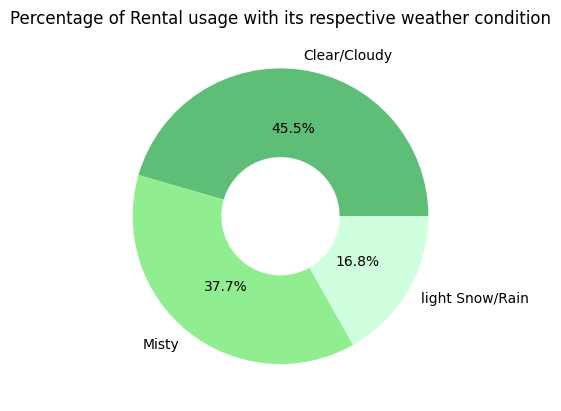

In [24]:
plt.title("Percentage of Rental usage with its respective weather condition")
plt.pie(
    x = weather_count["cnt"],
    labels = ("Clear/Cloudy", "Misty", "light Snow/Rain"),
    autopct = '%1.1f%%',
    colors = ["#5EBD77", "#90EE90", "#D0FFE0"],
    wedgeprops = {'width': 0.6}
)

Adapun visualisasi lainnya yang menghubungkan korelasi antara kondisi cuaca lainnya yaitu temperatur, kecepatan angin, dan kelembaban udara terhadap banyaknya penggunaan rental sepeda di setiap harinya. Data tersebut akan divisualisasikan dengan menggunakan Scatterplot (sns.regplot) berikut ini:

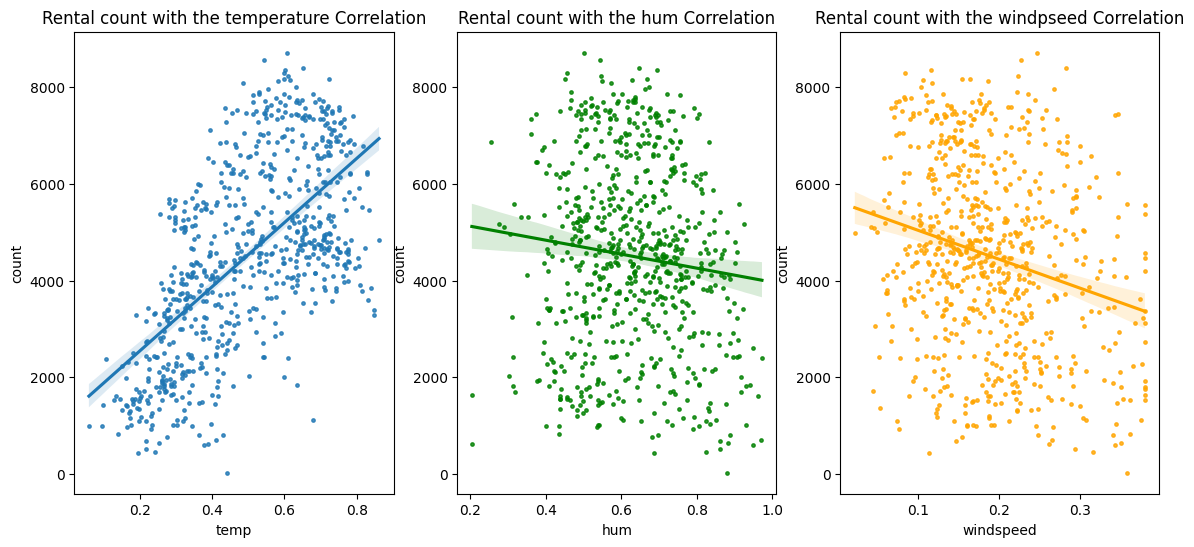

In [25]:
plt.figure(figsize=(14, 6))
plt.subplot(1,3,1)
sns.regplot(
    x = data_1["temp"],
    y = data_1["cnt"],
    scatter_kws={'s':6}
)
plt.ylabel("count"); plt.title("Rental count with the temperature Correlation")

plt.subplot(1,3,2)
sns.regplot(
    x = data_1["hum"],
    y = data_1["cnt"],
    scatter_kws={'s':6, 'color': 'green'},
    line_kws={"color": "green"}
)
plt.ylabel("count"); plt.title("Rental count with the hum Correlation")

plt.subplot(1,3,3)
sns.regplot(
    x = data_1["windspeed"],
    y = data_1["cnt"],
    scatter_kws={'s':6, 'color': 'orange'},
    line_kws={"color": "orange"}
)
plt.ylabel("count"); plt.title("Rental count with the windpseed Correlation")

plt.show()

### Pertanyaan 2:

Untuk pertanyaan kedua, visualisasi barplot akan digunakan untuk membandingkan jumlah pemakaian sepeda terhadap kedua atribut `workingday` dan `weekday`:

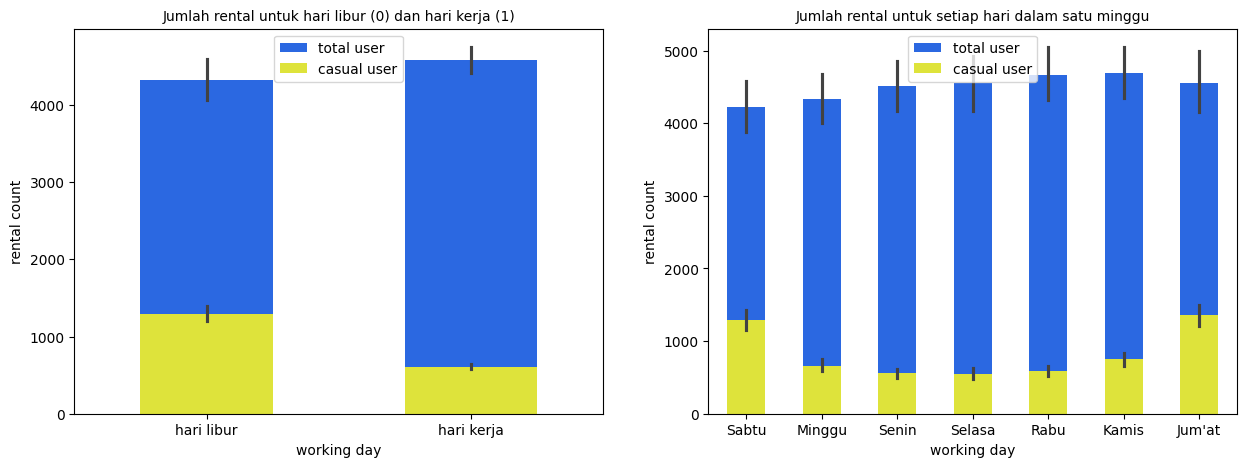

In [26]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1,2,1)
ax1 = sns.barplot(x = data_2["workingday"], y = data_2["cnt"], color = '#0d5eff', width = 0.5, label = "total user")
ax1 = sns.barplot(x = data_2["workingday"], y = data_2["casual"], color = '#f8ff1f', width = 0.5, label = "casual user")
plt.title("Jumlah rental untuk hari libur (0) dan hari kerja (1)", size = 10); plt.legend(loc="upper center")
plt.xticks(range(2), ["hari libur", "hari kerja"])
plt.xlabel("working day"); plt.ylabel("rental count")

ax2 = plt.subplot(1,2,2)
ax2 = sns.barplot(x = data_2["weekday"], y = data_2["cnt"], color = '#0d5eff', width = 0.5, label = "total user")
ax2 = sns.barplot(x = data_2["weekday"], y = data_2["casual"], color = '#f8ff1f', width = 0.5, label = "casual user")
plt.title("Jumlah rental untuk setiap hari dalam satu minggu", size = 10); plt.legend(loc="upper center")
plt.xticks(range(7), ["Sabtu", "Minggu", "Senin", "Selasa", "Rabu", "Kamis", "Jum'at"])
plt.xlabel("working day"); plt.ylabel("rental count")
plt.show()

untuk mellihat data dengan lebih jelas, maka visualisasi data dengan menggunakan pie chart akan diaplikasikan ke data di atas untuk melihat persentase jumlah rental sepeda untuk masing-masing dari kedua atribut `workingday` dan `weekday` seperti berikut ini:

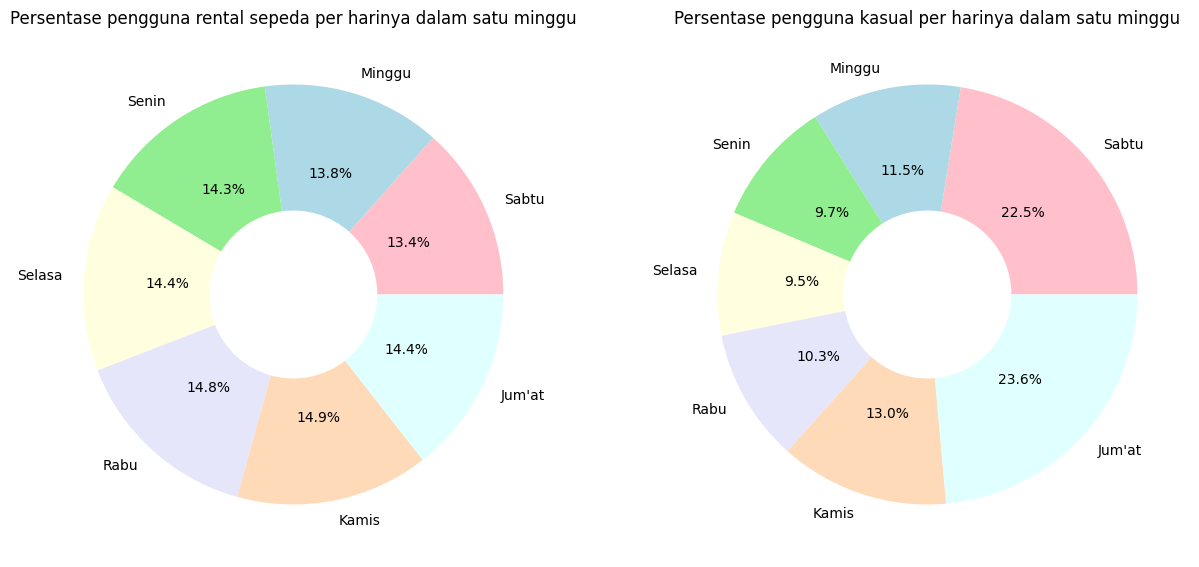

In [27]:
plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2,2,3)
plt.title("Persentase pengguna rental sepeda per harinya dalam satu minggu")
plt.pie(x = week_data["cnt"], autopct = '%1.1f%%', 
        labels = ["Sabtu", "Minggu", "Senin", "Selasa", "Rabu", "Kamis", "Jum'at"],
        colors = ['#FFC0CB', '#ADD8E6', '#90EE90', '#FFFFE0', '#E6E6FA', '#FFDAB9', '#E0FFFF'], wedgeprops = {'width': 0.6})

ax1 = plt.subplot(2,2,4)
plt.title("Persentase pengguna kasual per harinya dalam satu minggu")
plt.pie(x = week_data["casual"], autopct = '%1.1f%%', 
        labels = ["Sabtu", "Minggu", "Senin", "Selasa", "Rabu", "Kamis", "Jum'at"],
        colors = ['#FFC0CB', '#ADD8E6', '#90EE90', '#FFFFE0', '#E6E6FA', '#FFDAB9', '#E0FFFF'], wedgeprops = {'width': 0.6})

plt.show()

## Conclusion

##### Kesimpulan pertanyaan pertama

Kesimpulan yang dapat diambil dari hasil analisis data dari pertanyaan pertama adalah bahwa:
- Penggunaan sepeda rental akan memnuncak ketika cuaca sedang cerah atau berawan, keberadaan awan mendung atau awan berkabut cenderung akan mengurangi jumlah penggunaan sepeda rental akan berkurang secara signifikan, bahkan akan menurun drastis ketika di hari tersebut terjadi hujan atau salju ringan.
- Tidak ada penggunaan sepeda rental di suatu heri di mana terjadi badai salju atau hujan lebat yang disertai oleh petir atau hujan es. Kesimpulan tersebut dapat diambil dari tidak ada satupun baris/*row* yang memiliki value `4` dalam kolom atribut `weathersit`.
- Dapat disimpulkan juga bahwa kondisi temperatur cuaca di suatu hari juga mempengaruhi jumlah penggunaan sepeda rental dengan korelasi berbanding lurus, di mana semakin tinggi temperatur di hari tersebut, maka penggunaan speda rental juga akan cenderung meningkat.
- Belum bisa disimpulkan bahwa kecepatan angin mempengaruhi jumlah penggunaan sepeda rental, korelasi yang dimiliki oleh atribut `windspeed` dengan jumlah penggunaan sepeda rental tidak begitu terlihat dan cenderung lebih mendekati ke nilai korelasi nol. Maka dari itu, kesimpulan diambil bahwa korelasi tersebut terlihat sedikit mengarah ke korelasi negatif/berbanding terbalik, di mana pengguna akan meningkat di kecepatan angin rendah dengan peningkatan yang tidak begitu signifikan.
- Namun hal tersebut tidak dipengaruhi oleh kelembaban udara, karena jumlah penggunaan sepeda rental tidak memiliki korelasi dengan kondisi kelembaban cuaca di hari tersebut.

##### Kesimpulan pertanyaan kedua

Kesimpulan yang dapat diambil dari hasil analisis data dari pertanyaan kedua adalah bahwa:
- Jumlah penggunaan sepeda rental akan meningkat relatif sedikit pada hari kerja dibandingkan pada hari libur. Namun hal tersebut berbanding terbalik untuk jumlah pengguna kasual sepeda rental, di mana pengguna kasual cenderung meningkat di hari libur dibandingkan di hari kerja.
- Persentase rata-rata jumlah penggunaan sepeda di setiap harinya dalam satu minggu cenderung seragam tanpa adanya perubahan jumlah penggunaan sepeda rental yang signifikan. Namun pengguna kasual sepeda rental bertambah secara drastis ketika memasuki hari Jum'at dan Sabtu.